In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

sns.set(style='darkgrid', palette='muted', font_scale=1.5, rc={'figure.figsize':(20,10)})

RANDOM_SEED = 40
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [61]:
import glob
import pickle
def open_best_results():
    files = glob.glob('./fitted_models/*.pkl')
    
    all_models = []
    for file in files:
        with open(file, 'rb') as f:
            [all_models.append(df) for df in pickle.load(f)] 
    return all_models

In [81]:
best_dfs = open_best_results()
print(len(best_dfs))

4


In [82]:
def get_top(df_list, num):
    return sorted(df_list, key=lambda df: df['score']['r2'], reverse=True)[:num]

In [83]:
top_dfs = get_top(best_dfs, 10)

### Make predictions DF based on prev x_train & first x_test

In [144]:
def predict_on_predictions(df_list):
    next_week_predictions = []
    
    next_week_x = pd.DataFrame({
        'artiklar': [y[0] for y in df_list[0]['y_test']],
        'weekday': [0, 1, 2, 3, 4, 5, 6],
        'day_of_month': [22, 23, 24, 25, 26, 27, 28],
        'holiday': [0 for _ in range(7)],
        'before_holiday': [0 for _ in range(7)],
        'payday': [0, 0, 0, 1, 0, 0, 0],
        'pension': [0 for _ in range(7)]
    })
    
    for df in df_list:
        x_df = pd.DataFrame(df['X_test'][0], columns=df['features'])
        x_df['pred_artiklar'] = x_df['artiklar']
        
        scaled_next_week = pd.concat((x_df, pd.DataFrame(df['scaler_x'].transform(next_week_x[df['features']]), columns=x_df.columns[:-1])))
        
        model = keras.models.load_model(df['model'])
        
        for i in range(7):
            y_pred = model.predict(scaled_next_week.iloc[i:i + df['time_steps'], :-1].to_numpy().reshape(-1, df['X_train'].shape[1], df['X_train'].shape[2]))
            scaled_next_week.iloc[(i + df['time_steps']), -1] = y_pred[0]
        
        for i in ['artiklar', 'pred_artiklar']:
            scaled_next_week[i] = df['scaler_y'].inverse_transform(scaled_next_week[i].to_numpy().reshape(-1, 1))
        
        # TODO unscale all x Values 
        df['new_score'] = {'RMSE': np.sqrt(mean_squared_error(y_true=df['y_test'], y_pred=df['predictions'])),
                           'MAE': mean_absolute_error(y_true=df['y_test'], y_pred=df['predictions']),
                           'r2': r2_score(y_true=df['y_test'], y_pred=df['predictions'])}
        
        next_week_pred = scaled_next_week.reset_index()

        df['next_week'] = next_week_pred
        
        next_week_predictions.append(df)
        
    return next_week_predictions

In [85]:
for d in top_dfs:
    print(d['score'])

{'RMSE': 684.2725715199655, 'MAE': 506.97041906629266, 'r2': 0.8022163807982878}
{'RMSE': 690.4591536098036, 'MAE': 543.1804771423338, 'r2': 0.7986238475946803}
{'RMSE': 1490.3419821901769, 'MAE': 1126.6142229352674, 'r2': 0.0617816417064212}
{'RMSE': 1495.7323790519176, 'MAE': 1130.5489850725442, 'r2': 0.0549825106096703}


In [145]:
next_week_predictions = predict_on_predictions(top_dfs)

In [146]:
def plot_all_predictions(df_list):
    
    rows = len(df_list) // 3 if len(df_list) % 3 == 0 else (len(df_list) // 3) + 1
    
    fig, axes = plt.subplots(rows, 3, figsize=(25, rows * 5))
    fig.suptitle('Next week predictions', size=30)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.set_title(f'R2: {df_list[i]["new_score"]["r2"]:0.4f} RMSE: {df_list[i]["new_score"]["RMSE"]:0.2f} MAE: {df_list[i]["new_score"]["MAE"]:0.2f}', size=15)
        ax.plot(df_list[i]['next_week']['artiklar'], label='True', marker='.')
        ax.plot(df_list[i]['next_week']['pred_artiklar'], label='Predicted', marker='.')
        ax.legend(loc="upper right", prop={'size': 12})
        ax.tick_params(labelsize=12)
        if i == len(df_list) - 1:
            break

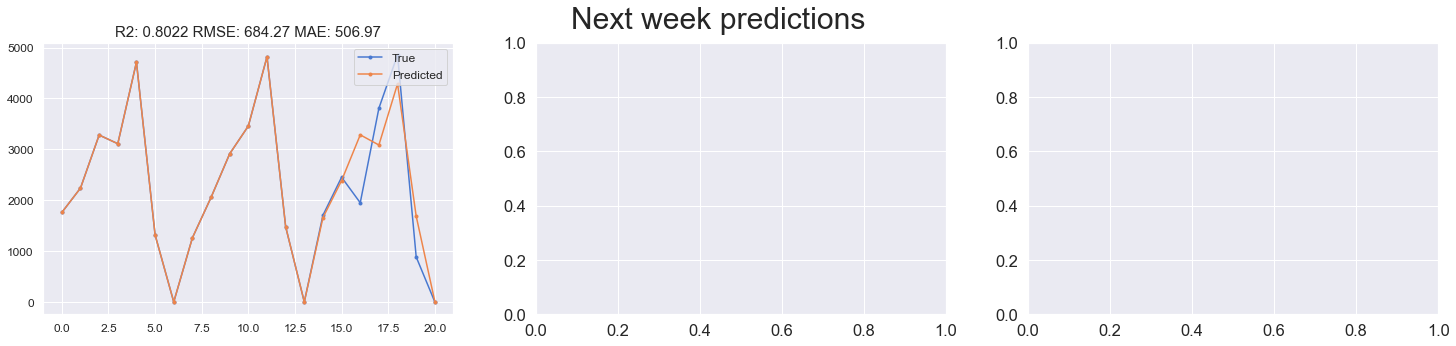

In [147]:
plot_all_predictions(next_week_predictions)